# Data Preprocessing and Model Training
This notebook performs data preprocessing and trains a Random Forest classifier on the Titanic dataset.

## Importing Libraries
We import necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading Dataset
Load the Titanic dataset from a CSV file.

In [2]:
Dataset=pd.read_csv('tested.csv')
Dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Stratified Shuffle Split
We split the dataset into training and testing sets using stratified sampling based on 'Survived', 'Pclass', and 'Sex' to maintain the distribution of these features.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)

for train_indices,test_indices in split.split(Dataset,Dataset[['Survived','Pclass','Sex']]):
    Train_set=Dataset.loc[train_indices]
    Test_set=Dataset.loc[test_indices]

## Visualizing the Split
Plot histograms of 'Survived' and 'Pclass' for both training and testing sets to verify the stratified split.

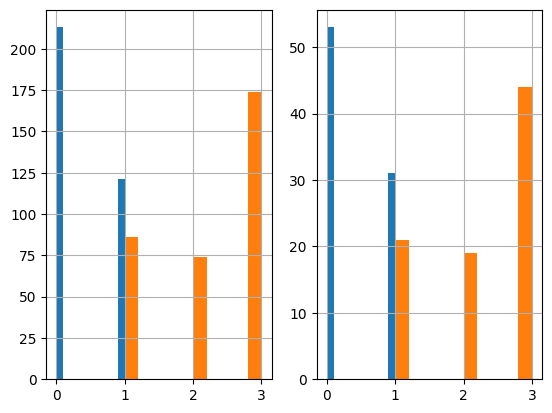

In [4]:
plt.subplot(1,2,1)
Train_set['Survived'].hist()
Train_set['Pclass'].hist()

plt.subplot(1,2,2)
Test_set['Survived'].hist()
Test_set['Pclass'].hist()

plt.show()

## Custom Transformer: Age Imputer
Define a transformer to impute missing values in the 'Age' column using the mean strategy.

In [5]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        imputer=SimpleImputer(strategy="mean")
        X['Age']=imputer.fit_transform(X[['Age']])
        return X

## Custom Transformer: Feature Encoder
Encode categorical features 'Embarked' and 'Sex' using one-hot encoding and add them as new columns.

In [6]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        encoder=OneHotEncoder()
        matrix=encoder.fit_transform(X[['Embarked']]).toarray()
        column_names=["C","S","Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        matrix=encoder.fit_transform(X[['Sex']]).toarray()
        column_names=["Female","Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        return X

## Custom Transformer: Feature Dropper
Drop unnecessary columns that are not used for modeling.

In [7]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"],axis=1,errors="ignore")

## Pipeline Creation
Create a pipeline to apply the custom transformers sequentially.

In [8]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer",AgeImputer()),
                    ("featureencoder",FeatureEncoder()),
                    ("featuredropper",FeatureDropper())])

## Transform Training Set
Apply the pipeline transformations to the training set.

In [9]:
Train_set=pipeline.fit_transform(Train_set)
Train_set.to_csv('train_set.csv',index=False)

## Feature Scaling
Scale the features using StandardScaler for better model performance.

In [10]:
from sklearn.preprocessing import StandardScaler

X=Train_set.drop(['Survived'],axis=1)
y=Train_set['Survived']

scaler=StandardScaler()
X_data=scaler.fit_transform(X)
y_data=y.to_numpy()

## Model Training with Random Forest and Grid Search
Train a Random Forest classifier and tune hyperparameters using GridSearchCV.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf=RandomForestClassifier()

param_grid=[
    {"n_estimators":[10,100,200,500],"max_depth":[None,5,10],"min_samples_split":[2,3,4]}
]

grid_search=GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data,y_data)
final_clf=grid_search.best_estimator_
final_clf

## Transform Test Set
Apply the same pipeline and scaling to the test set.

In [ ]:
Test_set=pipeline.fit_transform(Test_set)
X_test=Test_set.drop(['Survived'],axis=1)
y_test=Test_set['Survived']

scaler=StandardScaler()
X_data_test=scaler.fit_transform(X_test)
y_data_test=y_test.to_numpy()

## Model Evaluation
Evaluate the trained model on the test set.

In [ ]:
final_clf.score(X_data_test,y_data_test)